# Book Recommendation: Preprocess

Clean out the data, fix misaligned columns, only keep the ratings of the books and users whose data we have

Raw Data: https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset?resource=download

Preprocessed Data: Uploaded to Github

# Setup

In [1]:
!pip install tensorflow_probability

In [2]:
%tensorflow_version 1.x
import tensorflow as tf
import numpy as np
import numpy.random as npr
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
import statsmodels.api as sm

from tensorflow_probability import edward2 as ed
from sklearn.datasets import load_breast_cancer
from pandas.plotting import scatter_matrix
from scipy import sparse, stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, mean_squared_error, r2_score
from sklearn.utils import shuffle

import matplotlib
matplotlib.rcParams.update({'font.sans-serif' : 'Helvetica',
                            'axes.labelsize': 10,
                            'xtick.labelsize' : 6,
                            'ytick.labelsize' : 6,
                            'axes.titlesize' : 10})
import matplotlib.pyplot as plt

import seaborn as sns
color_names = ["windows blue",
               "amber",
               "crimson",
               "faded green",
               "dusty purple",
               "greyish"]
colors = sns.xkcd_palette(color_names)
sns.set(style="white", palette=sns.xkcd_palette(color_names), color_codes = False)

TensorFlow 1.x selected.


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
books = pd.read_csv('/content/Books.csv')
users = pd.read_csv('/content/Users.csv')
ratings = pd.read_csv('/content/Ratings.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [7]:
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [8]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


# Data Cleaning and Preprocessing

In [9]:
books.columns = ['ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication', 'publisher', 'imageUrlS', 'imageUrlM', 'imageUrlL']
#dropping last three columns containing image URLs which will not be required for analysis
books.drop(['imageUrlS', 'imageUrlM', 'imageUrlL'],axis=1,inplace=True)

In [10]:
# Clean Data
#investigating the rows having 'DK Publishing Inc' as yearOfPublication
books.loc[books.yearOfPublication == 'DK Publishing Inc',:]



,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
209538,078946697X,"DK Readers: Creating the X-Men, How It All Beg...",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.0...
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Book...",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.0...


In [11]:
#From above, it is seen that bookAuthor is incorrectly loaded with bookTitle, hence making required corrections
#ISBN '0789466953'
books.loc[books.ISBN == '0789466953','yearOfPublication'] = 2000
books.loc[books.ISBN == '0789466953','bookAuthor'] = "James Buckley"
books.loc[books.ISBN == '0789466953','publisher'] = "DK Publishing Inc"
books.loc[books.ISBN == '0789466953','bookTitle'] = "DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)"

#ISBN '078946697X'
books.loc[books.ISBN == '078946697X','yearOfPublication'] = 2000
books.loc[books.ISBN == '078946697X','bookAuthor'] = "Michael Teitelbaum"
books.loc[books.ISBN == '078946697X','publisher'] = "DK Publishing Inc"
books.loc[books.ISBN == '078946697X','bookTitle'] = "DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)"

#rechecking
books.loc[(books.ISBN == '0789466953') | (books.ISBN == '078946697X'),:]
#corrections done

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
209538,078946697X,"DK Readers: Creating the X-Men, How It All Beg...",Michael Teitelbaum,2000,DK Publishing Inc
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Book...",James Buckley,2000,DK Publishing Inc


In [12]:
#investigating the rows having 'Gallimard' as yearOfPublication
books.loc[books.yearOfPublication == 'Gallimard',:]

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers\"";Jean-M...",2003,Gallimard,http://images.amazon.com/images/P/2070426769.0...


In [13]:
#making required corrections as above, keeping other fields intact
books.loc[books.ISBN == '2070426769','yearOfPublication'] = 2003
books.loc[books.ISBN == '2070426769','bookAuthor'] = "Jean-Marie Gustave Le ClÃ?Â©zio"
books.loc[books.ISBN == '2070426769','publisher'] = "Gallimard"
books.loc[books.ISBN == '2070426769','bookTitle'] = "Peuple du ciel, suivi de 'Les Bergers"


books.loc[books.ISBN == '2070426769',:]

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers",Jean-Marie Gustave Le ClÃ?Â©zio,2003,Gallimard


In [14]:
books.yearOfPublication=pd.to_numeric(books.yearOfPublication, errors='coerce')

print(sorted(books['yearOfPublication'].unique()))
#Now it can be seen that yearOfPublication has all values as integers

[0, 1376, 1378, 1806, 1897, 1900, 1901, 1902, 1904, 1906, 1908, 1909, 1910, 1911, 1914, 1917, 1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2008, 2010, 2011, 2012, 2020, 2021, 2024, 2026, 2030, 2037, 2038, 2050]


In [15]:
#However, the value 0 is invalid and as this dataset was published in 2004, we have assumed the the years after 2006 to be 
#invalid keeping some margin in case dataset was updated thereafer
#setting invalid years as NaN
books.loc[(books.yearOfPublication > 2006) | (books.yearOfPublication == 0),'yearOfPublication'] = np.NAN

#replacing NaNs with mean value of yearOfPublication
books.yearOfPublication.fillna(round(books.yearOfPublication.mean()), inplace=True)

In [16]:
#rechecking
books.yearOfPublication.isnull().sum()
#No NaNs

0

In [17]:
#resetting the dtype as int32
books.yearOfPublication = books.yearOfPublication.astype(np.int32)

In [18]:
#exploring 'publisher' column
books.loc[books.publisher.isnull(),:]
#two NaNs

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
128890,193169656X,Tyrant Moon,Elaine Corvidae,2002,NaN
129037,1931696993,Finders Keepers,Linnea Sinclair,2001,NaN


In [19]:
#investigating rows having NaNs
#Checking with rows having bookTitle as Tyrant Moon to see if we can get any clues
books.loc[(books.bookTitle == 'Tyrant Moon'),:]
#no clues

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
128890,193169656X,Tyrant Moon,Elaine Corvidae,2002,NaN


In [20]:
#since there is nothing in common to infer publisher for NaNs, replacing these with 'other
books.loc[(books.ISBN == '193169656X'),'publisher'] = 'other'
books.loc[(books.ISBN == '1931696993'),'publisher'] = 'other'


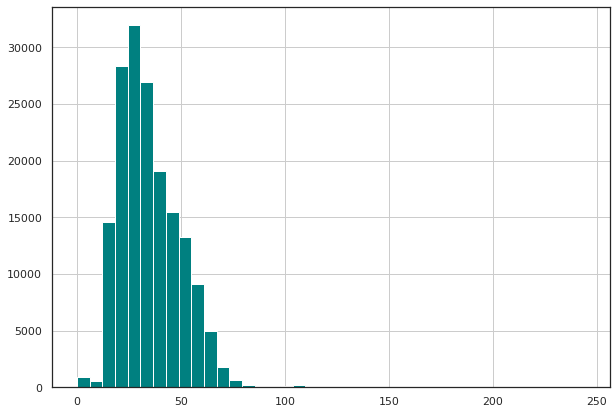

In [21]:
plt.figure(figsize=(10, 7))
users.Age.hist(bins=40, color='teal')
#Age column has some invalid entries like nan, 0 and very high values like 100 and above

In [22]:
#In my view values below 5 and above 90 do not make much sense for our book rating case...hence replacing these by NaNs
users.loc[(users.Age > 90) | (users.Age < 5), 'Age'] = np.nan

#replacing NaNs with mean
users.Age = users.Age.fillna(users.Age.mean())

#setting the data type as int
users.Age = users.Age.astype(np.int32)

In [23]:
#ratings dataset will have n_users*n_books entries if every user rated every item, this shows that the dataset is very sparse
n_users = users.shape[0]
n_books = books.shape[0]
n_users * n_books

75670906880

In [24]:
ratings['Book-Rating'].unique()

array([ 0,  5,  3,  6,  8,  7, 10,  9,  4,  1,  2])

In [25]:
#ratings dataset should have books only which exist in our books dataset, unless new books are added to books dataset
ratings_new = ratings[ratings.ISBN.isin(books.ISBN)]

ratings.shape,ratings_new.shape
#it can be seen that many rows having book ISBN not part of books dataset got dropped off

((1149780, 3), (1031136, 3))

In [26]:
#ratings dataset should have ratings from users which exist in users dataset, unless new users are added to users dataset
ratings_final = ratings_new[ratings_new['User-ID'].isin(users['User-ID'])]

print(ratings_final.shape)
print(ratings_new.shape)
#no new users added, hence we will go with above dataset ratings_new (1031136, 3)

(n_users), (n_books)

(1031136, 3)
(1031136, 3)


(278858, 271360)

In [28]:
# save preprocessed data
ratings_final.to_csv ('/content/ratings_clean.csv', index=None)
users.to_csv ('/content/users_clean.csv', index=None)
books.to_csv ('/content/books_clean.csv', index=None)

## EDA

In [30]:
#Hence segragating implicit and explict ratings datasets
ratings_explicit = ratings_new[ratings_new['Book-Rating'] != 0]
ratings_implicit = ratings_new[ratings_new['Book-Rating'] == 0]

(1031136, 3)
(383842, 3)
(647294, 3)


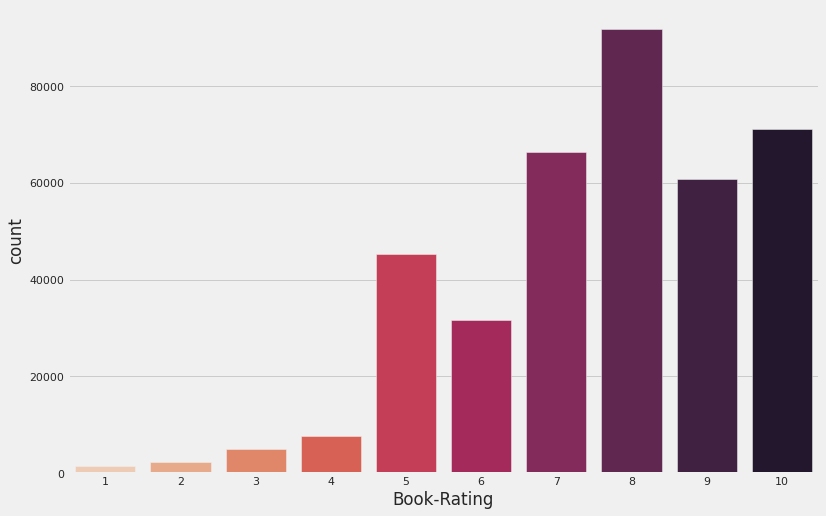

In [31]:
print(ratings_new.shape)
print(ratings_explicit.shape)
print(ratings_implicit.shape)
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12, 8))
sns.countplot(data=ratings_explicit , x='Book-Rating', palette='rocket_r')

#Popularity Based Recommendation

In [32]:
ratings_count = pd.DataFrame(ratings_explicit.groupby(['ISBN'])['Book-Rating'].sum())
top10 = ratings_count.sort_values('Book-Rating', ascending = False).head(10)

top10.merge(books, left_index = True, right_on = 'ISBN')

#Given below are top 10 recommendations based on popularity. It is evident that books authored by J.K. Rowling are most popular

,Book-Rating,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
408,5787,0316666343,The Lovely Bones: A Novel,Alice Sebold,2002,"Little, Brown"
748,4108,0385504209,The Da Vinci Code,Dan Brown,2003,Doubleday
522,3134,0312195516,The Red Tent (Bestselling Backlist),Anita Diamant,1998,Picador USA
2143,2798,059035342X,Harry Potter and the Sorcerer's Stone (Harry P...,J. K. Rowling,1999,Arthur A. Levine Books
356,2595,0142001740,The Secret Life of Bees,Sue Monk Kidd,2003,Penguin Books
26,2551,0971880107,Wild Animus,Rich Shapero,2004,Too Far
1105,2524,0060928336,Divine Secrets of the Ya-Ya Sisterhood: A Novel,Rebecca Wells,1997,Perennial
706,2402,0446672211,Where the Heart Is (Oprah's Book Club (Paperba...,Billie Letts,1998,Warner Books
231,2219,0452282152,Girl with a Pearl Earring,Tracy Chevalier,2001,Plume Books
118,2179,0671027360,Angels &amp; Demons,Dan Brown,2001,Pocket Star


In [33]:
#Similarly segregating users who have given explicit ratings from 1-10 and those whose implicit behavior was tracked
users_exp_ratings = users[users['User-ID'].isin(ratings_explicit['User-ID'])]
users_imp_ratings = users[users['User-ID'].isin(ratings_implicit['User-ID'])]

In [34]:
#checking shapes
print(users.shape)
print(users_exp_ratings.shape)
print(users_imp_ratings.shape)

(278858, 3)
(68091, 3)
(52451, 3)
